In [ ]:
#!pip install keras_cv

#Работа с датасетом

## Подключение kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
!cp "/content/drive/MyDrive/Colab Notebooks/kaggle.json" ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

### Загрузка и распаковка dataset


In [ ]:
! kaggle datasets download -d nikhilroxtomar/person-segmentation

100% 459M/461M [00:02<00:00, 238MB/s]
100% 461M/461M [00:02<00:00, 217MB/s]


In [ ]:
import zipfile
import os

if not os.path.exists("/content/dataset"):
  with zipfile.ZipFile("/content/person-segmentation.zip", 'r') as zip_ref:
      zip_ref.extractall("/content")

In [ ]:
!mv "/content/people_segmentation" "/content/dataset"
!rm -r "/content/person-segmentation.zip"

##Обработка данных

In [ ]:
import os
import numpy as np
from glob import glob
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split
from albumentations import HorizontalFlip, GridDistortion, OpticalDistortion,\
                           ChannelShuffle, CoarseDropout, CenterCrop, Crop, Rotate

###Дополнительные функцции бработки данных

In [ ]:
def create_dir(path):
  if not os.path.exists(path):
    os.makedirs(path)

def load_data_set(path):
  x = sorted(glob(os.path.join(path, "images", "*jpg")))
  y = sorted(glob(os.path.join(path, "masks", "*png")))
  return x, y

def split_dataset(path, split = 0.1):
  """Загрузка изображений и масок"""
  X, Y = load_data_set(path)

  """Разбиение на тестовую и валидационную выборку"""
  split_size = int(len(X) * split)

  train_x, test_x = train_test_split(X, test_size=split_size, random_state=42)
  train_y, test_y = train_test_split(Y, test_size=split_size, random_state=42)

  return (train_x, train_y), (test_x, test_y)

In [ ]:
def augment_data(images, masks, save_path, augment=True):
    def apply_augmentation(image, mask, aug):
        augmented = aug(image=image, mask=mask)
        return augmented['image'], augmented['mask']

    def save_images(image, mask, name, index):
        temp_imgage_name = f"{name}_{index}.png"
        temp_mask_name = f"{name}_{index}.png"
        image_path = os.path.join(save_path, "images", temp_imgage_name)
        mask_path = os.path.join(save_path, "masks", temp_mask_name)
        cv2.imwrite(image_path, image)
        cv2.imwrite(mask_path, mask)

    def process_image(x, y, nameFile):
        try:
            aug = CenterCrop(HEIGHT, WIDTH, p=1.0)
            augmentation = aug(image=x, mask=y)
            x, y = augmentation["image"], augmentation["mask"]
        except Exception as e:
            x = cv2.resize(x, (WIDTH, HEIGHT))
            y = cv2.resize(y, (WIDTH, HEIGHT))
        return x, y

    """Произведем аугментацию данных"""
    for x, y in tqdm(zip(images, masks), total=len(images)):
        nameFile = os.path.basename(x).split('.')[0]
        x, y = cv2.imread(x, cv2.IMREAD_COLOR), cv2.imread(y, cv2.IMREAD_COLOR)

        if augment:
            aug_1 = HorizontalFlip(p=1)
            x1, y1 = apply_augmentation(x, y, aug_1)

            x2, y2 = cv2.cvtColor(x, cv2.COLOR_RGB2GRAY), y

            aug_3 = ChannelShuffle(p=1)
            x3, y3 = apply_augmentation(x, y, aug_3)

            aug_4 = CoarseDropout(p=1, min_holes=3, max_holes=10, max_height=32, max_width=32)
            x4, y4 = apply_augmentation(x, y, aug_4)

            aug_5 = Rotate(limit=45, p=1.0)
            x5, y5 = apply_augmentation(x, y, aug_5)

            X = [x, x1, x2, x3, x4, x5]
            Y = [y, y1, y2, y3, y4, y5]

        else:
            X = [x]
            Y = [y]

        """Сохраняем данные"""
        index = 0
        for image, mask in zip(X, Y):
            image, mask = process_image(image, mask, nameFile)
            save_images(image, mask, nameFile, index)
            index += 1

###MAIN FOR DATASET

In [ ]:
""" Global parameters """
HEIGHT = 512
WIDTH = 512

def main_dataset():
  """Seeding"""
  np.random.seed(42)

  if not os.path.isdir('/content/new_data/train/images'):
    """Подгружаем данные"""
    data_path = "/content/dataset"
    (train_x, train_y), (test_x, test_y) = split_dataset(data_path)

    """Создаем выходные директории"""
    create_dir("/content/new_data/train/images/")
    create_dir("/content/new_data/train/masks/")
    create_dir("/content/new_data/test/images/")
    create_dir("/content/new_data/test/masks/")

  if not os.listdir("/content/new_data/train/images"):
    """Data augmentation"""
    augment_data(train_x, train_y, "/content/new_data/train/", augment=True)
    augment_data(test_x, test_y, "/content/new_data/test/", augment=False)

In [ ]:
main_dataset()

100%|██████████| 567/567 [00:17<00:00, 32.65it/s]


In [ ]:
def fast_test_data(path, split = 0.1):
  """Загрузка изображений и масок"""
  X, Y = load_data_set(path)

  """Разбиение на тестовую и валидационную выборку"""
  split_size = int(len(X) * split)

  train_x, test_x = train_test_split(X, test_size=split_size, random_state=42)
  train_y, test_y = train_test_split(Y, test_size=split_size, random_state=42)

  create_dir("/content/new_data/test/images/")
  create_dir("/content/new_data/test/masks/")

  augment_data(test_x, test_y, "/content/new_data/test/", augment=False)

In [ ]:
# fast_test_data('/content/dataset')

In [ ]:
#!rm -r "/content/new_data"

Добавить функцию по выбору фото разрешения не меньше заданного

#U-NET

##Теоретическая часть

###Архитектура

<img src="https://www.mdpi.com/diagnostics/diagnostics-12-03081/article_deploy/html/images/diagnostics-12-03081-g001.png" width=900>

##Части архитектуры

**Import**

In [ ]:
import tensorflow as tf
import keras
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU
from keras.layers import BatchNormalization, Conv2DTranspose, Concatenate
from keras.models import Model, Sequential

**Сверточный слой**

In [ ]:
def convolution_operation(entered_input, filters=64):
  """ Реализуем первый блок conv"""
  conv1 = Conv2D(filters, kernel_size=(3, 3), padding="same")(entered_input)
  batch_norm1 = BatchNormalization()(conv1)
  act1 = ReLU()(batch_norm1)

  """Реализуем второй блок conv"""
  conv2 = Conv2D(filters, kernel_size = (3, 3), padding = "same")(act1)
  batch_norm2 = BatchNormalization()(conv2)
  act2 = ReLU()(batch_norm2)

  return act2


**Кодер**

In [ ]:
def encoder(entered_input, filters = 64):
  """ Вызываем двойную свертку, макспулинг и верном оба для последующего
      использования в decodere """
  enc1 = convolution_operation(entered_input, filters)
  maxPool1 = MaxPooling2D(strides = (2, 2))(enc1)

  return enc1, maxPool1

**Декодер**

In [ ]:
def decoder(entered_input, skip, filters=64):
  """ Повышаем дискретизацию и объединяем слои [[a11..a1n, b11..b1n],..] """
  upsample = Conv2DTranspose(filters, kernel_size=(2, 2),\
                             strides=2, padding="same")(entered_input)
  connect_Skip = Concatenate()([upsample, skip])
  out = convolution_operation(connect_Skip, filters)

  return out

##Построение архитектуры U-Net:

In [ ]:
def U_Net(image_size):
  """Берем размеры и форму изображения"""
  input_1 = Input(image_size)

  """Создаем блоки энкодера"""
  skip_1, encoder_1 = encoder(input_1, 64)
  skip_2, encoder_2 = encoder(encoder_1, 64 * 2)
  skip_3, encoder_3 = encoder(encoder_2, 64 * 4)
  skip_4, encoder_4 = encoder(encoder_3, 64 * 8)

  """Создаем блок перед декодером"""
  conv_block = convolution_operation(encoder_4, 64 * 16)

  """Создаем блоки декодера"""
  decoder_1 = decoder(conv_block, skip_4, 64*8)
  decoder_2 = decoder(decoder_1, skip_3, 64*4)
  decoder_3 = decoder(decoder_2, skip_2, 64*2)
  decoder_4 = decoder(decoder_3, skip_1, 64)

  out = Conv2D(1, 1, padding="same", activation="sigmoid")(decoder_4)

  model = Model(input_1, out)

  return model

tf.keras.metrics.MeanIoU(num_classes=2) можно использовать всместо моей реализации

In [ ]:
def main_train_U_net(model = None):
  """ Seeding """
  np.random.seed(42)
  tf.random.set_seed(42)

  """ Хранений итоговых файлов """
  models_path = "/content/drive/MyDrive/Colab Notebooks/Models" + "/u_net"
  create_dir(models_path)

  """ Гиперпараметр """
  batch_size = 8
  lr = 1e-4
  num_epochs = 10
  model_path = os.path.join(models_path, "model_u_net.h5")
  csv_path = os.path.join(models_path, "data_u_net.csv")

  """ Набор данных """
  main_dataset()
  dataset_path = "/content/new_data"

  train_path = os.path.join(dataset_path, "train")
  valid_path = os.path.join(dataset_path, "test")

  train_x, train_y = load_data(train_path)
  train_x, train_y = shuffling(train_x, train_y)
  valid_x, valid_y = load_data(valid_path)

  print(f"Train: {len(train_x)} - {len(train_y)}")
  print(f"Valid: {len(valid_x)} - {len(valid_y)}")

  train_dataset = tf_dataset(train_x, train_y, batch=batch_size) # (8,512,512,3)
  valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size) # (8,512,512,1)

  """ Модель """
  if model is None:
    model = U_Net((HEIGHT, WIDTH, 3))
  model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=[dice_coef, iou, Recall(), Precision()])

  """"""
  callbacks = [
      ModelCheckpoint(model_path, verbose=1, save_best_only=True),
      ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
      CSVLogger(csv_path),
      TensorBoard(),
      EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False),
  ]

  model.fit(
      train_dataset,
      epochs=num_epochs,
      validation_data=valid_dataset,
      callbacks=callbacks
  )

In [ ]:
""" Загрузка модели """
models_path = "/content/drive/MyDrive/Colab Notebooks/Models" + "/u_net"
with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_loss': dice_loss}):
  model = tf.keras.models.load_model(os.path.join(models_path,"model_u_net.h5"))

main_train_U_net(model)

* Нужно как-то уменьшить количество данных в эпоху. Зависит от batcsize
* поиграться с обучением, чтобы чеще были чекпоинты и как-то запоминать какие данные я загружал в модель.


С другой стороны данных много

Train: 30666 - 30666

Valid: 567 - 567

Epoch 1/10

1092/3834 [=======>......................] - ETA: 1:29:55 - loss: 0.3456 - dice_coef: 0.6544 - iou: 0.4929 - recall: 0.8063 - precision: 0.5658

3834/3834 [==============================] - 7735s 2s/step - loss: 0.2810 - dice_coef: 0.7190 - iou: 0.5689 - recall: 0.8211 - precision: 0.6474 - val_loss: 0.2544 - val_dice_coef: 0.7458 - val_iou: 0.6001 - val_recall: 0.6750 - val_precision: 0.8484 - lr: 1.0000e-04

Epoch 2/10
 865/3834 [=====>........................] - ETA: 1:37:19 - loss: 0.2123 - dice_coef: 0.7877 - iou: 0.6550 - recall: 0.8434 - precision: 0.7456


 ETA: 0s - loss: 0.1949 - dice_coef: 0.8051 - iou: 0.6790 - recall: 0.8567 - precision: 0.7661

 После перезапуска:

 loss: 0.1569 - dice_coef: 0.8431 - iou: 0.7359 - recall_1: 0.8765 - precision_1: 0.816

#DeepLabV3+ with ResNet50

In [ ]:
""" Global parameters """
HEIGHT = 512
WIDTH = 512

##Теория

<img src="https://learnopencv.com/wp-content/uploads/2022/12/Deeplabv3-plus_complete_architrecture-1536x820.png" alt="DeepLabV3+ architecture"  width="900" align="center"/>



Atrous convolution - визитная карточка нейронных сетей DeepLab.
Он отличается от слоев обычной свертки тем, что фильтр умножается не
на оригинальный сигнал, а на сигнал, взятый с определенным показателем
rate. Это то же самое, что использовать фильтр, прореженный нулями.
Такой вид свертки позволяет получать информацию на разных масштабах
изображения.

<img src="https://media.springernature.com/full/springer-static/image/art%3A10.1186%2Fs41038-018-0137-9/MediaObjects/41038_2018_137_Fig5_HTML.png" width=800>|

[Статья про слой SqueezeAndExcite2D](https://arxiv.org/pdf/1709.01507.pdf)

## Реализация сети

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

from keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from keras.layers import AveragePooling2D, GlobalAveragePooling2D, UpSampling2D, Reshape, Dense
from keras.applications import ResNet50

import tensorflow as tf

###Additional functions

In [ ]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding=padding,
        use_bias=use_bias,
    )(block_input)
    x = BatchNormalization()(x)
    return Activation("relu")(x)


In [ ]:
def ASPP(dspp_input):
  """Пулинг"""
  shape = dspp_input.shape
  x = AveragePooling2D(pool_size=(shape[1], shape[2]))(dspp_input)
  x = convolution_block(x, kernel_size=1)
  out_pool = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(x)

  """Свертки"""
  out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
  out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
  out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
  out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

  x = Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
  out = convolution_block(x, kernel_size=1, dilation_rate=1)
  return out

In [ ]:
def SqueezeAndExcite(inputs, ratio=8):
    init = inputs
    filters = init.shape[-1]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    x = init * se
    return x

В качестве энкодара будет ResNet50.
Параметр weights="imagenet" в модели ResNet50 указывает на предварительно обученные веса модели на наборе данных ImageNet.
include_top=False значит, что мы не хотим также класифицировать объекты.

##Построение архитектуры DeepLabV3+

In [ ]:
def deepLabV3_plus(shape):
  inputs = Input(shape)

  encoder = ResNet50(weights="imagenet", include_top=False, input_tensor=inputs)

  image_features = encoder.get_layer("conv4_block6_out").output
  input_a = ASPP(image_features)
  input_a = UpSampling2D((4, 4), interpolation="bilinear")(input_a)

  input_b = encoder.get_layer("conv2_block2_out").output
  input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

  x = Concatenate()([input_a, input_b])
  x = SqueezeAndExcite(x)

  x = convolution_block(x)
  x = convolution_block(x)
  x = SqueezeAndExcite(x)

  x = UpSampling2D((4, 4), interpolation="bilinear")(x)
  x = Conv2D(1, 1)(x) # filter 1

  x = Activation("sigmoid")(x)

  return Model(inputs, x)

In [ ]:
model = deepLabV3_plus((512, 512, 3))
# model.summary()

#Train

In [ ]:
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from keras.optimizers import Adam
from keras.metrics import Recall, Precision

###Функции предобработки датасета

In [ ]:
def shuffling(x, y):
  x, y = shuffle(x, y, random_state=42)
  return x, y

def load_data(path):
  x = sorted(glob(os.path.join(path, "images", "*png")))
  y = sorted(glob(os.path.join(path, "masks", "*png")))
  return x, y

###Тренировка

* Будем сохранять модель
* Уменьшать скорость обучения, если нет улучшений
* Обратный вызов, который передает результаты epoch в CSV-файл.
* Используем визуализацию для TensorBoard.
* Используем ранную остановку

In [ ]:
def main_train_deepLabV3_plus():
  """ Seeding """
  np.random.seed(42)
  tf.random.set_seed(42)

  """ Хранений итоговых файлов """
  models_path = "/content/drive/MyDrive/Colab Notebooks/Models" + "/deepLabV3_plus"
  create_dir(models_path)

  """ Гиперпараметр """
  batch_size = 2
  lr = 1e-4
  num_epochs = 20
  model_path = os.path.join(models_path, "model_deepLabV3_plus.h5")
  csv_path = os.path.join(models_path, "data_deepLabV3_plus.csv")

  """ Набор данных """
  main_dataset()
  dataset_path = "/content/new_data"

  train_path = os.path.join(dataset_path, "train")
  valid_path = os.path.join(dataset_path, "test")

  train_x, train_y = load_data(train_path)
  train_x, train_y = shuffling(train_x, train_y)
  valid_x, valid_y = load_data(valid_path)

  print(f"Train: {len(train_x)} - {len(train_y)}")
  print(f"Valid: {len(valid_x)} - {len(valid_y)}")

  train_dataset = tf_dataset(train_x, train_y, batch=batch_size) # (2,512,512,3)
  valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size) # (2,512,512,1)

  """ Модель """
  model = deepLabV3_plus((HEIGHT, WIDTH, 3))
  model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=[dice_coef, iou, Recall(), Precision()])

  callbacks = [
      ModelCheckpoint(model_path, verbose=1, save_best_only=True),
      ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
      CSVLogger(csv_path),
      TensorBoard(),
      EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False),
  ]

  model.fit(
      train_dataset,
      epochs=num_epochs,
      validation_data=valid_dataset,
      callbacks=callbacks
  )

In [ ]:
# main_train_deepLabV3_plus()

In [ ]:
def read_image(path):
  path = path.decode()
  x = cv2.imread(path, cv2.IMREAD_COLOR)
  x = x/255.0
  x = x.astype(np.float32)
  return x

def read_mask(path):
  path = path.decode()
  x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
  x = x.astype(np.float32)
  x = np.expand_dims(x, axis=-1) #
  return x

def tf_parse(x, y):
  def _parse(x, y):
    x = read_image(x)
    y = read_mask(y)
    return x, y

  x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
  # уточняем размеры
  x.set_shape([HEIGHT, WIDTH, 3])
  y.set_shape([HEIGHT, WIDTH, 1])
  return x, y

def tf_dataset(X, Y, batch=2):
  # Создаем пары из изображений и масок
  dataset = tf.data.Dataset.from_tensor_slices((X, Y))
  # Создаем из из путей(картинок) тензоры
  dataset = dataset.map(tf_parse)
  # Группируем
  dataset = dataset.batch(batch)
  # Производим загрузку данных в буфер памяти во время обучения для асинхронности
  dataset = dataset.prefetch(10)
  return dataset


###Метрики нейронной сети

#### Dice Loss



Dice Loss основан на коэффициенте Сёренсена или мере сходства Дайса, которая измеряет сходство между двумя выборками. Это значение лежит в диапазоне от 0 до 1, где 1 означает идеальное совпадение между двумя образцами.

Формула для коэффициента Дайса:
$$ Dice=\frac{2∣A∩B∣}{∣A∣+∣B|}$$

где |A| и |B| - размеры двух множеств. Dice Loss - это 1 минус коэффициент Дайса, что делает его функцией потерь. Чем ближе значение Dice Loss к нулю, тем лучше.

[Другие метрики](https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch)


#### Intersection over Union (IoU)



IoU измеряет степень перекрытия между предсказанной областью (например, сегментированной маской) и истинной меткой (истинной областью) на изображении.

Формула:
$$IoU=\frac{∣A∩B∣}{∣A∪B∣}$$​

Значение IoU также находится в диапазоне от 0 до 1, и чем ближе значение к 1, тем лучше.

[Видео обзор](https://www.youtube.com/watch?v=RgQbweTwrkU)

Разница между ними заключается в способе измерения сходства между предсказанной и истинной областями:

- **Dice Loss** является функцией потерь, ориентированной на оптимизацию совпадения между предсказанными и истинными областями. Чем ближе значение Dice Loss к нулю, тем лучше модель сегментации.
- **IoU** является метрикой, измеряющей степень перекрытия между предсказанной и истинной областями. Чем ближе значение IoU к 1, тем лучше сегментация.


####Другие

[Accuracy, precision и recall и другие](https://habr.com/ru/companies/ods/articles/328372/)

####Код

In [ ]:
import numpy as np
import tensorflow as tf

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

##Валидация сети

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import cv2
import pandas as pd
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from keras.utils import CustomObjectScope
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score

""" Global parameters """
HEIGHT = 512
WIDTH = 512

def save_results(image, mask, y_pred, save_image_path):
  ## i - m - yp - yp*i
  line = np.ones((HEIGHT, 10, 3)) * 128

  mask = np.expand_dims(mask, axis=-1)    ## (512, 512, 1)
  mask = np.concatenate([mask, mask, mask], axis=-1)  ## (512, 512, 3)
  mask = mask * 255

  y_pred = np.expand_dims(y_pred, axis=-1)    ## (512, 512, 1)
  y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)  ## (512, 512, 3)

  masked_image = image * y_pred
  y_pred = y_pred * 255

  cat_images = np.concatenate([image, line, mask, line, y_pred, line, masked_image], axis=1)
  cv2.imwrite(save_image_path, cat_images)



In [ ]:
""" Seeding """
np.random.seed(42)
tf.random.set_seed(42)

""" Создание директирий для хранения """
result_path = "/content/drive/MyDrive/Colab Notebooks/Result/" + "deepLabV3_plus"
create_dir(result_path)

""" Загрузка модели """
models_path = "/content/drive/MyDrive/Colab Notebooks/Models" + "/deepLabV3_plus"
with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_loss': dice_loss}):
    model = tf.keras.models.load_model(os.path.join(models_path,"model_deepLabV3_plus.h5"))

""" Загрузка dataset """
dataset_path = "/content/new_data"
valid_path = os.path.join(dataset_path, "test")
test_x, test_y = load_data(valid_path)
print(f"Test: {len(test_x)} - {len(test_y)}")

Test: 567 - 567


In [ ]:
""" Оценка и прогнозирование """
SCORE = []
for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
  name = os.path.basename(x).split('.')[0]

  """ Считывание изображения как 1 пакета"""
  image = cv2.imread(x, cv2.IMREAD_COLOR)
  x = image/255.0
  x = np.expand_dims(x, axis=0)

  """ Считывание маски """
  mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)

  """ Предсказание """
  y_pred = model.predict(x)[0]
  y_pred = np.squeeze(y_pred, axis=-1)
  y_pred = y_pred > 0.5
  y_pred = y_pred.astype(np.int32)

  """ Сохранение предсказания """
  save_image_path = os.path.join(result_path, f"{name}.png")
  save_results(image, mask, y_pred, save_image_path)

  """ Выровняйте массив """
  mask = mask.flatten()
  y_pred = y_pred.flatten()

  """ Вычисление значений показателей """
  acc_value = accuracy_score(mask, y_pred)
  f1_value = f1_score(mask, y_pred, labels=[0, 1], average="binary")
  jac_value = jaccard_score(mask, y_pred, labels=[0, 1], average="binary")
  recall_value = recall_score(mask, y_pred, labels=[0, 1], average="binary")
  precision_value = precision_score(mask, y_pred, labels=[0, 1], average="binary")
  SCORE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value])

  break
""" Metrics values """
score = [s[1:]for s in SCORE]
score = np.mean(score, axis=0)
print(f"Accuracy: {score[0]:0.5f}")
print(f"F1: {score[1]:0.5f}")
print(f"Jaccard: {score[2]:0.5f}")
print(f"Recall: {score[3]:0.5f}")
print(f"Precision: {score[4]:0.5f}")

df = pd.DataFrame(SCORE, columns=["Image", "Accuracy", "F1", "Jaccard", "Recall", "Precision"])
df.to_csv(models_path + "/score_deepLabV3_plus.csv")

  0%|          | 0/567 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


  0%|          | 0/567 [00:03<?, ?it/s]

Accuracy: 0.97741
F1: 0.98253
Jaccard: 0.96565
Recall: 0.98826
Precision: 0.97686


##Тестирование на фото

In [ ]:
from functools import partial
from tqdm import tqdm

tqdm = partial(tqdm, position=0, leave=True)

In [ ]:
!rm -r "/content/test_images/mask"

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import cv2
import pandas as pd
from glob import glob
from tqdm.notebook import tqdm
import tensorflow as tf
from keras.utils import CustomObjectScope

""" Global parameters """
HEIGHT = 512
WIDTH = 512

def save(image, y, save_dir_name):
  """ Сохранение """
  h, _, _ = image.shape
  masked_image = image * y
  line = np.ones((h, 10, 3)) * 128
  cat_images = np.concatenate([image, line, masked_image], axis=1)
  cv2.imwrite(save_dir_name, cat_images)

def predict(image, model):
  h, w, _ = image.shape
  x = cv2.resize(image, (WIDTH, HEIGHT))
  x = x/255.0
  x = x.astype(np.float32)
  x = np.expand_dims(x, axis=0)

  """ Предсказание """
  y = model.predict(x)[0]
  y = cv2.resize(y, (w, h))
  y = np.expand_dims(y, axis=-1)

  return y

def test_images():
  """ Seeding """
  np.random.seed(42)
  tf.random.set_seed(42)

  """ Создание директирий для хранения """
  save_dir = "/content/test_images/mask"
  create_dir(save_dir)

  """ Загрузка модели """
  models_path = "/content/drive/MyDrive/Colab Notebooks/Models" + "/deepLabV3_plus"
  with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_loss': dice_loss}):
      model = tf.keras.models.load_model(os.path.join(models_path,"model_deepLabV3_plus.h5"))

  """ Load the dataset """
  data_x = glob("/content/drive/MyDrive/Colab Notebooks/Tests/Images/*")

  for path in tqdm(data_x):
    name = os.path.basename(path).split('.')[0]

    """ Считывание изображения как 1 пакета"""
    image = cv2.imread(path, cv2.IMREAD_COLOR)

    y = predict(image, model)

    save_dir_name = save_dir + f"/{name}.png"
    save(image, y, save_dir_name)


In [ ]:
# test_images()

In [ ]:
import requests
import numpy as np
import cv2
from io import BytesIO
from google.colab.patches import cv2_imshow
from keras.utils import CustomObjectScope


def download_and_read_image(url):
    try:
        response = requests.get(url)
        if response.status_code == 200:
            # Чтение изображения в формате numpy array
            image = np.asarray(bytearray(response.content), dtype="uint8")
            image = cv2.imdecode(image, cv2.IMREAD_COLOR)
            return image
        else:
            print("Не удалось загрузить изображение. Код состояния:", response.status_code)
            return None
    except Exception as e:
        print("Произошла ошибка:", e)
        return None

def show_pred_image(image):
  if image is not None:
    y = predict(image, model)
    h, _, _ = image.shape
    masked_image = image * y
    line = np.ones((h, 10, 3)) * 128
    cat_images = np.concatenate([image, line, masked_image], axis=1)
    cv2_imshow(cat_images)
  else:
      print("Изображение не загружено.")

In [ ]:
""" Загрузка модели """
models_path = "/content/drive/MyDrive/Colab Notebooks/Models" + "/deepLabV3_plus"
with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_loss': dice_loss}):
  model = tf.keras.models.load_model(os.path.join(models_path,"model_deepLabV3_plus.h5"))

In [ ]:
""" Загрузка модели """
models_path = "/content/drive/MyDrive/Colab Notebooks/Models" + "/u_net"
with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_loss': dice_loss}):
  model = tf.keras.models.load_model(os.path.join(models_path,"model_u_net.h5"))

1/1 [==============================] - 6s 6s/step


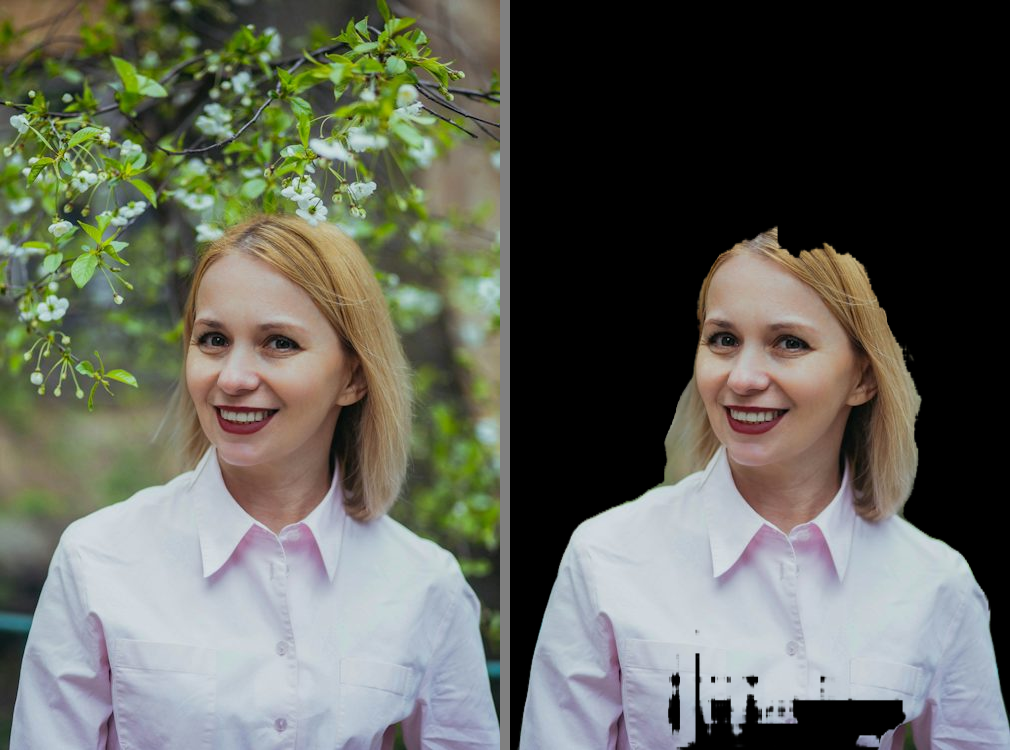

In [ ]:
image_url = "https://images.unsplash.com/photo-1589203832113-de9d078abc30?w=500&auto=format&fit=crop&q=60&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxzZWFyY2h8Mnx8cG9ydHJldHxlbnwwfHwwfHx8MA%3D%3D"  # Замените на нужную ссылку
downloaded_image = download_and_read_image(image_url)

show_pred_image(downloaded_image)

In [ ]:
print(model.loss)

<function dice_loss at 0x7d3d7fd060e0>


## Тестирование на видео

frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
Чтобы вывести шкалу обработки

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
import tensorflow as tf
from keras.utils import CustomObjectScope

def extract_path_info(file_path):
  directory = os.path.dirname(file_path)
  file_name = os.path.basename(file_path)
  name, extension = os.path.splitext(file_name)
  return directory, name, extension

def processing_video(video_path, fps = 30, model = None):
  """ Load the model """
  if not model:
    models_path = "/content/drive/MyDrive/Colab Notebooks/Models" + "/deepLabV3_plus"
    with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_loss': dice_loss}):
        model = tf.keras.models.load_model(os.path.join(models_path,"model_deepLabV3_plus.h5"))

  """ Reading frames """
  cap = cv2.VideoCapture(video_path)
  width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
  height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

  fourcc = cv2.VideoWriter_fourcc(*'MJPG')
  dir, name, _ = extract_path_info(video_path)
  # out = cv2.VideoWriter(os.path.join(dir, name + "_mask" + ".mp4"), fourcc, fps, (width, height), True)
  out = cv2.VideoWriter(f"{dir}/{name}_mask.mp4", fourcc, fps, (width, height), True)

  idx = 0
  while cap.isOpened():
    ret, frame = cap.read()
    if ret == False:
      break
    mask = predict(frame, model)

    combine_frame = frame * mask
    combine_frame = combine_frame.astype(np.uint8)

    out.write(combine_frame)

  cap.release()
  out.release()


In [ ]:
video_path = "/content/drive/MyDrive/Colab Notebooks/Tests/Videos/Video3.mp4"
processing_video(video_path)

#U2-NET

##Архитектура

[Статья](https://arxiv.org/pdf/2005.09007.pdf)

<img src="https://i2.wp.com/miro.medium.com/1*fuSxCIvebQBdzYgoSTCfzg.png">

<img src="https://avatars.mds.yandex.net/get-images-cbir/1039828/OFHcLh3-jkPZjqRqFD-uOw3864/ocr">

##Реализация

In [ ]:
""" Global parameters """
HEIGHT = 512
WIDTH = 512

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf
from keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate, Add
from keras.models import Model

def conv_block(inputs, out_ch, rate=1):
  x = Conv2D(out_ch, 3, padding="same", dilation_rate=1)(inputs)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)
  return x

def RSU_L(inputs, out_ch, int_ch, num_layers, rate=2):
  """ Начальная свертка Conv """
  x = conv_block(inputs, out_ch)
  init_feats = x

  """ Энкодер """
  skip = []
  x = conv_block(x, int_ch)
  skip.append(x)

  for i in range(num_layers-2):
    x = MaxPool2D((2, 2))(x)
    x = conv_block(x, int_ch)
    skip.append(x)

  """ Мост """
  x = conv_block(x, int_ch, rate=rate)

  """ Декодер """
  skip.reverse()

  x = Concatenate()([x, skip[0]])
  x = conv_block(x, int_ch)

  for i in range(num_layers-3):
    x = UpSampling2D(size=(2, 2), interpolation="bilinear")(x)
    x = Concatenate()([x, skip[i+1]])
    x = conv_block(x, int_ch)

  x = UpSampling2D(size=(2, 2), interpolation="bilinear")(x)
  x = Concatenate()([x, skip[-1]])
  x = conv_block(x, out_ch)

  """ Add """
  x = Add()([x, init_feats])
  return x

def RSU_4F(inputs, out_ch, int_ch):
  """ Начальная свертка Conv """
  x0 = conv_block(inputs, out_ch, rate=1)

  """ Энкодер """
  x1 = conv_block(x0, int_ch, rate=1)
  x2 = conv_block(x1, int_ch, rate=2)
  x3 = conv_block(x2, int_ch, rate=4)

  """ Мост """
  x4 = conv_block(x3, int_ch, rate=8)

  """ Декодер """
  x = Concatenate()([x4, x3])
  x = conv_block(x, int_ch, rate=4)

  x = Concatenate()([x, x2])
  x = conv_block(x, int_ch, rate=2)

  x = Concatenate()([x, x1])
  x = conv_block(x, out_ch, rate=1)

  """ Addition """
  x = Add()([x, x0])
  return x

In [ ]:
def RSU_block(x, out_ch, int_ch, num_blocks):
  if num_blocks == 3:
    return RSU_4F(x, out_ch, int_ch)
  else:
    return RSU_L(x, out_ch, int_ch, num_blocks)

def concatenate_and_rsu(u, s, out_ch, int_ch, num_blocks):
    d = Concatenate()([u, s])
    d = RSU_block(d, out_ch, int_ch, num_blocks)
    return d


def u2net(input_shape, out_ch, int_ch, num_classes=1):
  """ Входной слой """
  inputs = Input(input_shape)

  """ Энкодер """
  s = []
  pool_layer = inputs

  for i in range(5):
    s.append(RSU_block(pool_layer, out_ch[i], int_ch[i], 7 - i))
    pool_layer = MaxPool2D((2, 2))(s[i])

  """ Мост """
  b1 = RSU_4F(pool_layer, out_ch[5], int_ch[5])
  b2 = UpSampling2D(size=(2, 2), interpolation="bilinear")(b1)

  """ Декодер """
  upsample_layers = []
  u = b2
  for i in range(5):
    upsample_layers.append(concatenate_and_rsu(u, s[-1 - i], out_ch[6 + i], int_ch[6 + i], 3 + i))
    u = UpSampling2D(size=(2, 2), interpolation="bilinear")(upsample_layers[i])

  upsample_layers = [b1] + upsample_layers

  """ Выходной слой """
  y = Conv2D(num_classes, 3, padding="same")(upsample_layers[-1])
  side_outputs = [y]

  for i in range(1, 6):
    y = Conv2D(num_classes, 3, padding="same")(upsample_layers[-1 - i])
    y = UpSampling2D(size=(2**i, 2**i), interpolation="bilinear")(y)
    side_outputs.append(y)

  """ Финальный слой """
  final_output = Concatenate()(side_outputs)
  final_output = Conv2D(num_classes, 3, padding="same")(final_output)
  final_output = Activation("sigmoid")(final_output)

  side_outputs = [Activation("sigmoid")(layer) for layer in side_outputs]

  return Model(inputs, outputs=[final_output] + side_outputs)


In [ ]:
def build_u2net(input_shape, num_classes=1):
    out_ch = [64, 128, 256, 512, 512, 512, 512, 256, 128, 64, 64]
    int_ch = [32, 32, 64, 128, 256, 256, 256, 128, 64, 32, 16]
    model = u2net(input_shape, out_ch, int_ch, num_classes=num_classes)
    return model

def build_u2net_lite(input_shape, num_classes=1):
    out_ch = [64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64]
    int_ch = [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]
    model = u2net(input_shape, out_ch, int_ch, num_classes=num_classes)
    return model

In [ ]:
# build_u2net((WIDTH, HEIGHT, 3)).summary()

##Работа с датасетом

In [ ]:
import gdown

url = "https://drive.google.com/uc?export=download&id=1LqUU7BZeiq8I3i5KxApdOJ2haXm-cEv1"
output = '/content/dataset.zip'
gdown.download(url, output, quiet=False)

In [ ]:
import zipfile
import os

if not os.path.exists("/content/dataset"):
  with zipfile.ZipFile("/content/dataset.zip", 'r') as zip_ref:
      zip_ref.extractall("/content")

In [ ]:
# !rm -r "/content/datasset.zip"

##Тренировка

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

###Доп функции

In [ ]:
""" Global parameters """
HEIGHT = 512
WIDTH = 512

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def load_dataset(path, split=0.1):
    train_x = sorted(glob(os.path.join(path, "train", "blurred_image", "*.jpg")))
    train_y = sorted(glob(os.path.join(path, "train", "mask", "*.png")))

    valid_x = sorted(glob(os.path.join(path, "validation", "P3M-500-NP", "original_image", "*.jpg")))
    valid_y = sorted(glob(os.path.join(path, "validation", "P3M-500-NP", "mask", "*.png")))

    return (train_x, train_y), (valid_x, valid_y)

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (WIDTH, HEIGHT))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (WIDTH, HEIGHT))
    x = x / 255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([HEIGHT, WIDTH, 3])
    y.set_shape([HEIGHT, WIDTH, 1])
    return x, y

def tf_dataset(X, Y, batch=2):
    ds = tf.data.Dataset.from_tensor_slices((X, Y))
    ds = ds.map(tf_parse).batch(batch).prefetch(10)
    return ds

###Тренировка

In [ ]:
def train_u2net_main():
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Хранений итоговых файлов """
    models_path = "/content/drive/MyDrive/Colab Notebooks/Models" + "/u2_net"
    create_dir(models_path)

    """ Гиперпараметры """
    batch_size = 8
    lr = 1e-4
    num_epochs = 500
    model_path = os.path.join(models_path, "model_u2_net.h5")
    csv_path = os.path.join(models_path, "log_u2_net.csv")

    """ Dataset """
    dataset_path = "/content/P3M-10k"
    (train_x, train_y), (valid_x, valid_y) = load_dataset(dataset_path)

    print(f"Train: {len(train_x)} - {len(train_y)}")
    print(f"Valid: {len(valid_x)} - {len(valid_y)}")

    train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
    valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

    """ Model """
    model = build_u2net((HEIGHT, WIDTH, 3))
    if os.path.exists(model_path): model.load_weights(model_path)
    model.compile(loss="binary_crossentropy", optimizer=Adam(lr))

    callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path),
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False),
    ]

    model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=valid_dataset,
        callbacks=callbacks
    )

In [ ]:
train_u2net_main()

Train: 9421 - 9421
Valid: 500 - 500


  5%|▍         | 282M/5.79G [15:44<5:07:22, 299kB/s]


Epoch 1/500
